In [1]:
"""Analysis notebook for the Marconi HPC tests.
"""

import sys
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from matplotlib.cm import get_cmap

# Check Python version
py_ver = sys.version.split("\n")[0]
print(f"Hello, we are using Python {py_ver}")
del py_ver

Hello, we are using Python 3.7.3 (default, Mar 27 2019, 09:23:15) 


In [2]:
# Adjust figure size for Matplotlib
matplotlib.rcParams["figure.figsize"] = [16, 10]
matplotlib.rcParams["figure.dpi"] = 200

In [3]:
def to_bool(s):
    """Convert a string to bool.
    """
    return s.lower() in [ "true", "yes", "on", "1" ]

def get_tuple(raw, fields, cond={}, cond_eval="True"):
    """Given a list of dictionaries in `raw`, returns a tuple of lists, each one of them
       representing the fields specified by `fields`.
       Results are filtered by the conditions expressed in `cond` and `condEval`.
       Example:
           a,b = getTuple(plot_raw, ("nJobs", "wallTime"), {"nEvt": 200})
       Gets two lists: a with the list of nJobs, b with the list of wallTime.
       a,b can be passed as arguments to matplotlib plot functions.
    """
    x = ( tuple(map(x.get, fields)) for x in raw if all(x[k] == v for k,v in cond.items()) and \
                                                    (eval(cond_eval)) )
    return map(list, zip(*x))

def load_csv(csv_fn, cond_eval="True", quiet=False):
    """Loads from `csv_fn`, outputs a list of dictionaries.
       Performs type conversions in the process.
       Discards fields not matching `cond_eval`.
    """
    conv_default = int
    conv_map = { "success": to_bool, "shMem": to_bool, "cpuEff": float }
    sort_func = lambda x: 100000 * x.get("nEvt", 0) + \
                          1000 * x.get("nInst", 0) + \
                          x.get("nProc", 0) + x.get("nJobs", 0)
    raw = []
    with open(csv_fn) as ch:
        cr = csv.DictReader(ch)
        pk = True
        for rec in cr:
            if pk:
                print(f"Keys from {csv_fn}: {', '.join(rec.keys())}")
                pk = False
            # Convert field types
            for f in rec:
                typ = conv_map.get(f, conv_default)
                rec[f] = typ(rec[f])
            nEvt = rec["nEvt"]
            if eval(cond_eval):
                raw.append(dict(rec))
            elif not quiet:
                print(f"WARNING: discarded: {dict(rec)}")

    raw.sort(key=sort_func)
    return raw

Keys from scalability_proc.csv: jobId, nEvt, nJobs, success, shMem, cpuTime, wallTime, userCpu, aveRss, maxRss


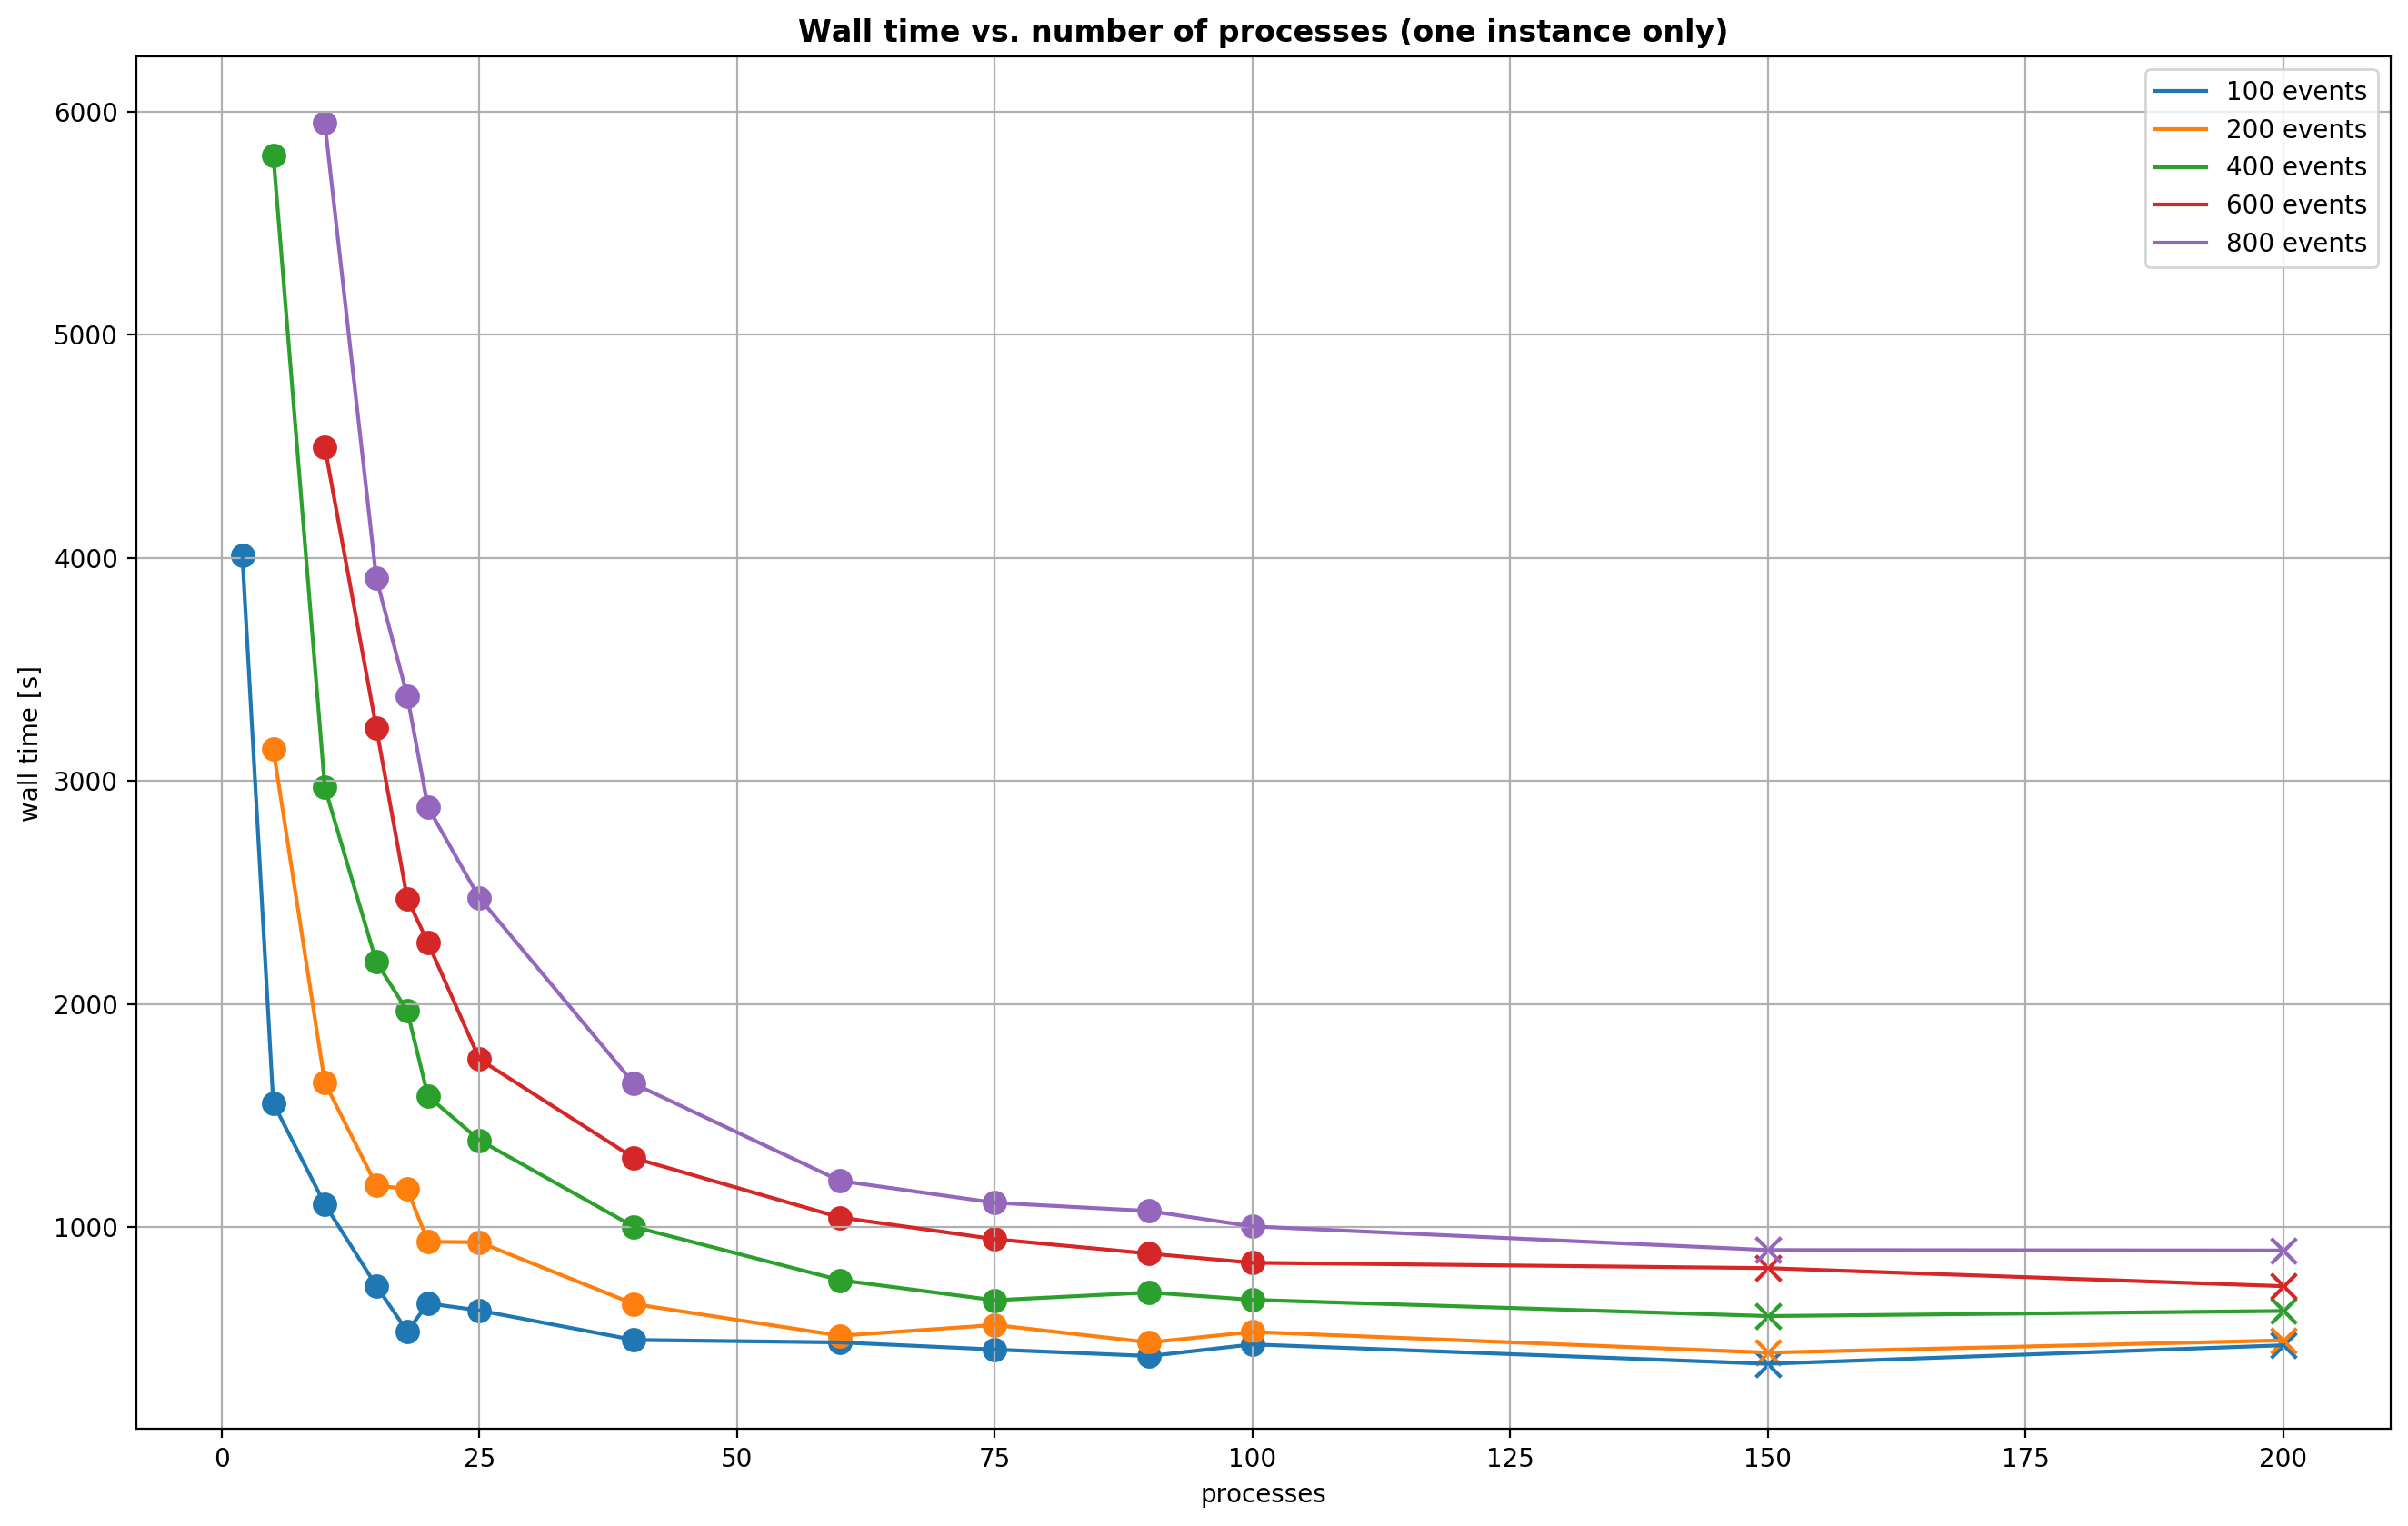

In [4]:
# Plot wall time vs. number of processes
scale_raw = load_csv("scalability_proc.csv", "rec['success']")
scale_fig,scale_ax = plt.subplots()
cycol = cycler("color", get_cmap("tab10").colors).__iter__()
for n_evt in sorted({x["nEvt"] for x in scale_raw}):
    x,y = get_tuple(scale_raw, ("nJobs", "wallTime"), {"nEvt": n_evt})
    prop = cycol.__next__()
    # Lines
    scale_ax.plot(x, y, "-", label=f"{n_evt} events", **prop)
    # Plot different dots if shMem or zmq
    x1,y1 = get_tuple(scale_raw, ("nJobs", "wallTime"), {"nEvt": n_evt, "shMem": True})   # shmem
    scale_ax.scatter(x1, y1, s=75, marker="o", **prop)
    x2,y2 = get_tuple(scale_raw, ("nJobs", "wallTime"), {"nEvt": n_evt, "shMem": False})   # zmq
    scale_ax.scatter(x2, y2, s=100, marker="x", **prop)
scale_ax.grid(True)
scale_ax.legend()
scale_ax.set_title("Wall time vs. number of processes (one instance only)", weight="bold")
scale_ax.set_xlabel("processes")
scale_ax.set_ylabel("wall time [s]")
del x, y, x1, y1, x2, y2, prop, cycol, n_evt

Keys from slurm_stats.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss


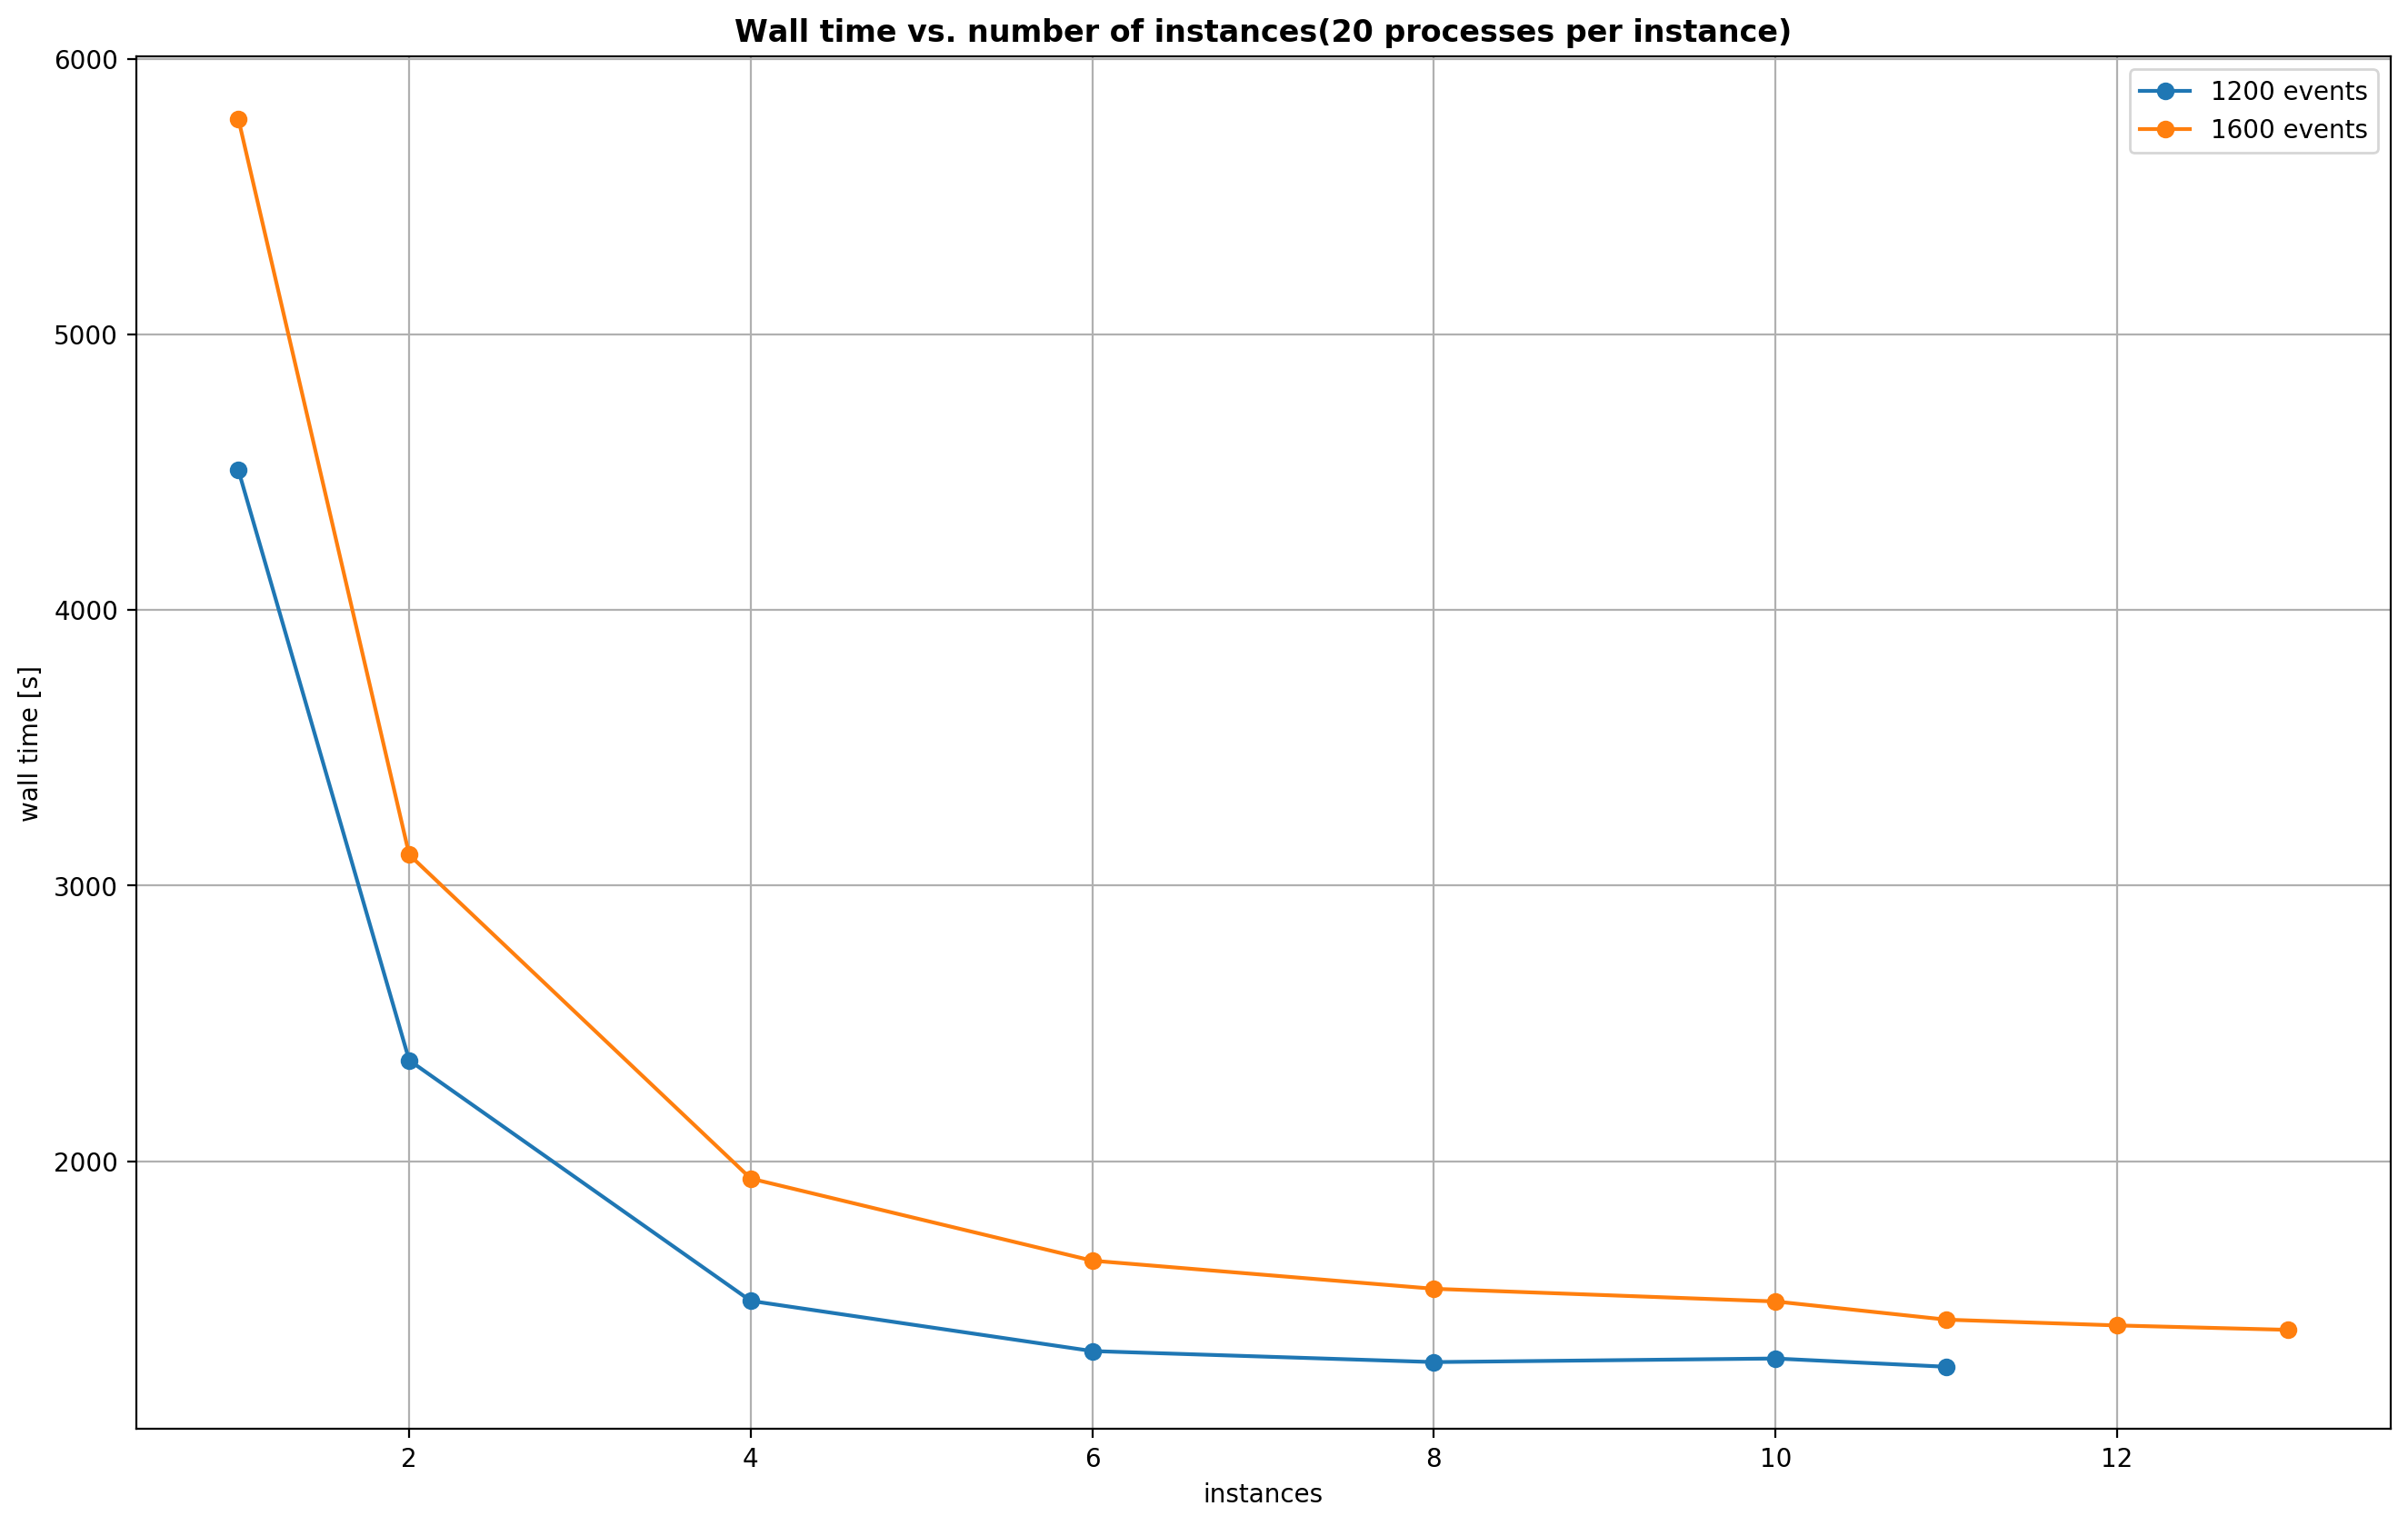

In [5]:
# Plot wall time vs. number of instances
mult_raw = load_csv("slurm_stats.csv", "rec['nInstOk'] == rec['nInst']")
mult_fig,mult_ax = plt.subplots()
cycol = cycler("color", get_cmap("tab10").colors).__iter__()
for n_evt in sorted({x["nEvt"] for x in mult_raw}):
    x,y = get_tuple(mult_raw, ("nInst", "slurmWallTime"), {"nEvt": n_evt})
    prop = cycol.__next__()
    # Lines
    mult_ax.plot(x, y, "o-", label=f"{n_evt} events", **prop)
mult_ax.grid(True)
mult_ax.legend()
mult_ax.set_title(f"Wall time vs. number of instances"
                  f"({mult_raw[0]['nProc']} processes per instance)",
                  weight="bold")
mult_ax.set_xlabel("instances")
mult_ax.set_ylabel("wall time [s]")
del x, y, prop, cycol, n_evt

Keys from psmon_slurm.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss
Keys from psmon.csv: jobId, nEvt, nProc, nInst, elapsed, cpuEff, vsz, rsz


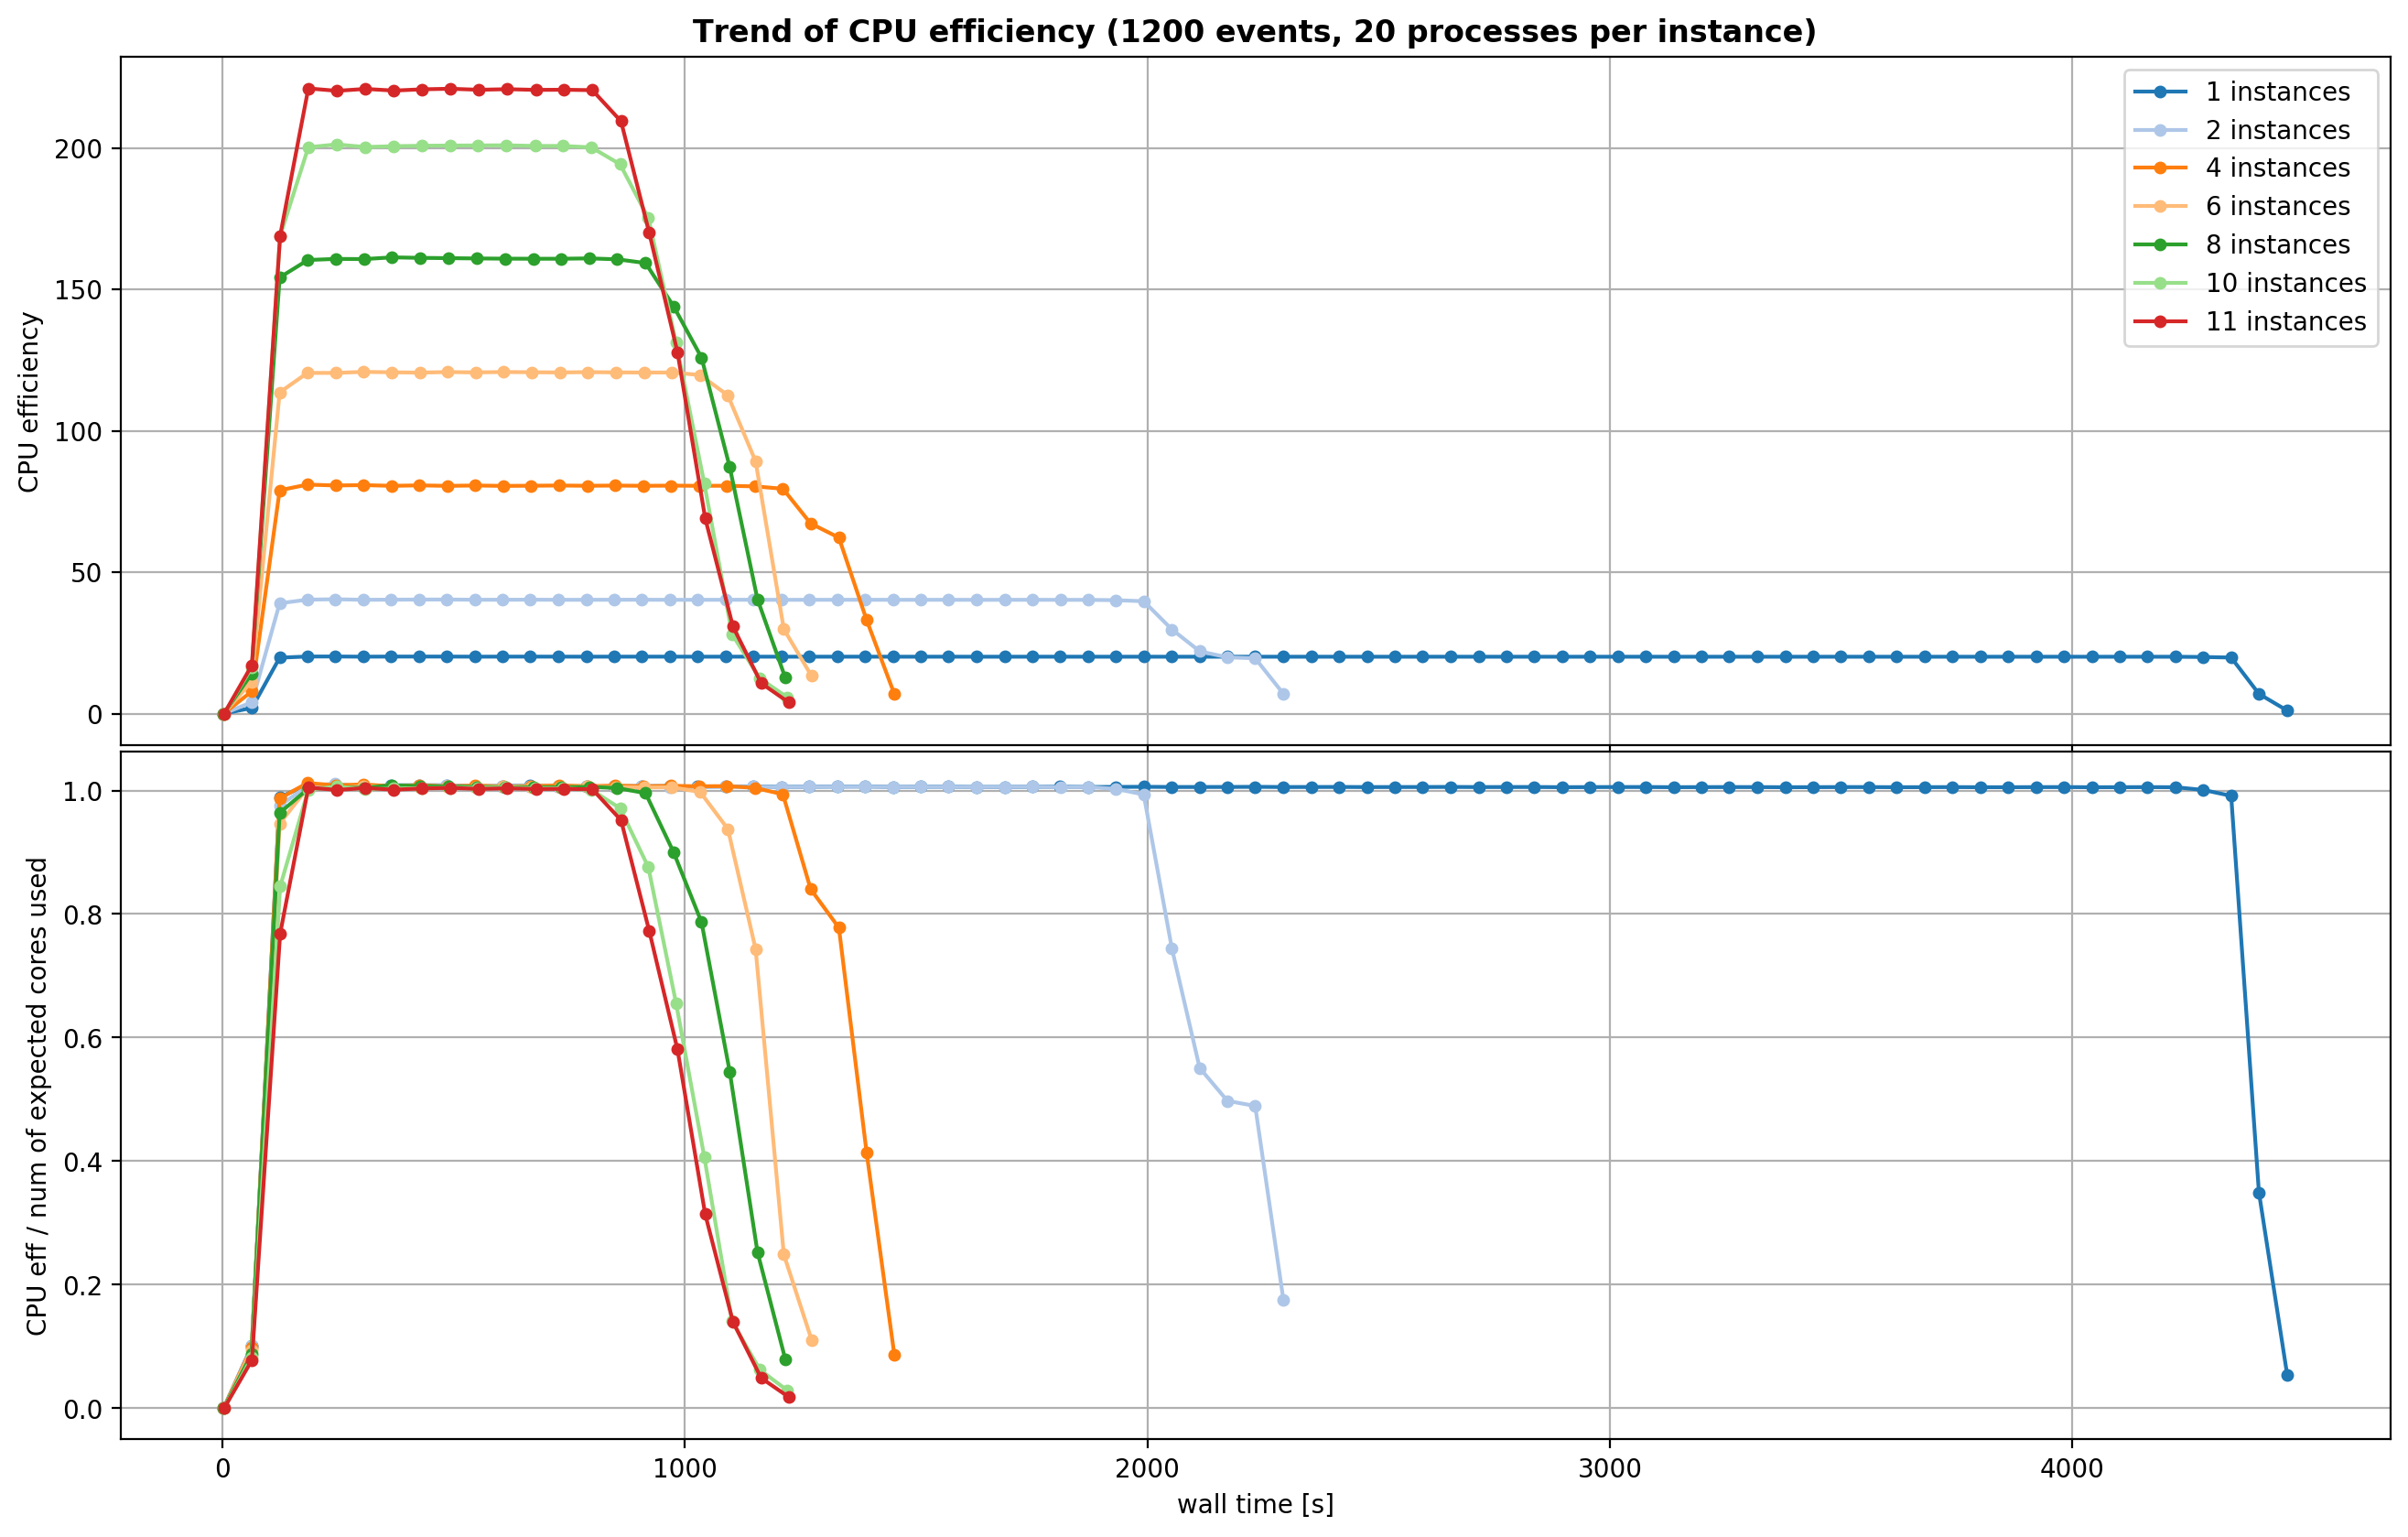

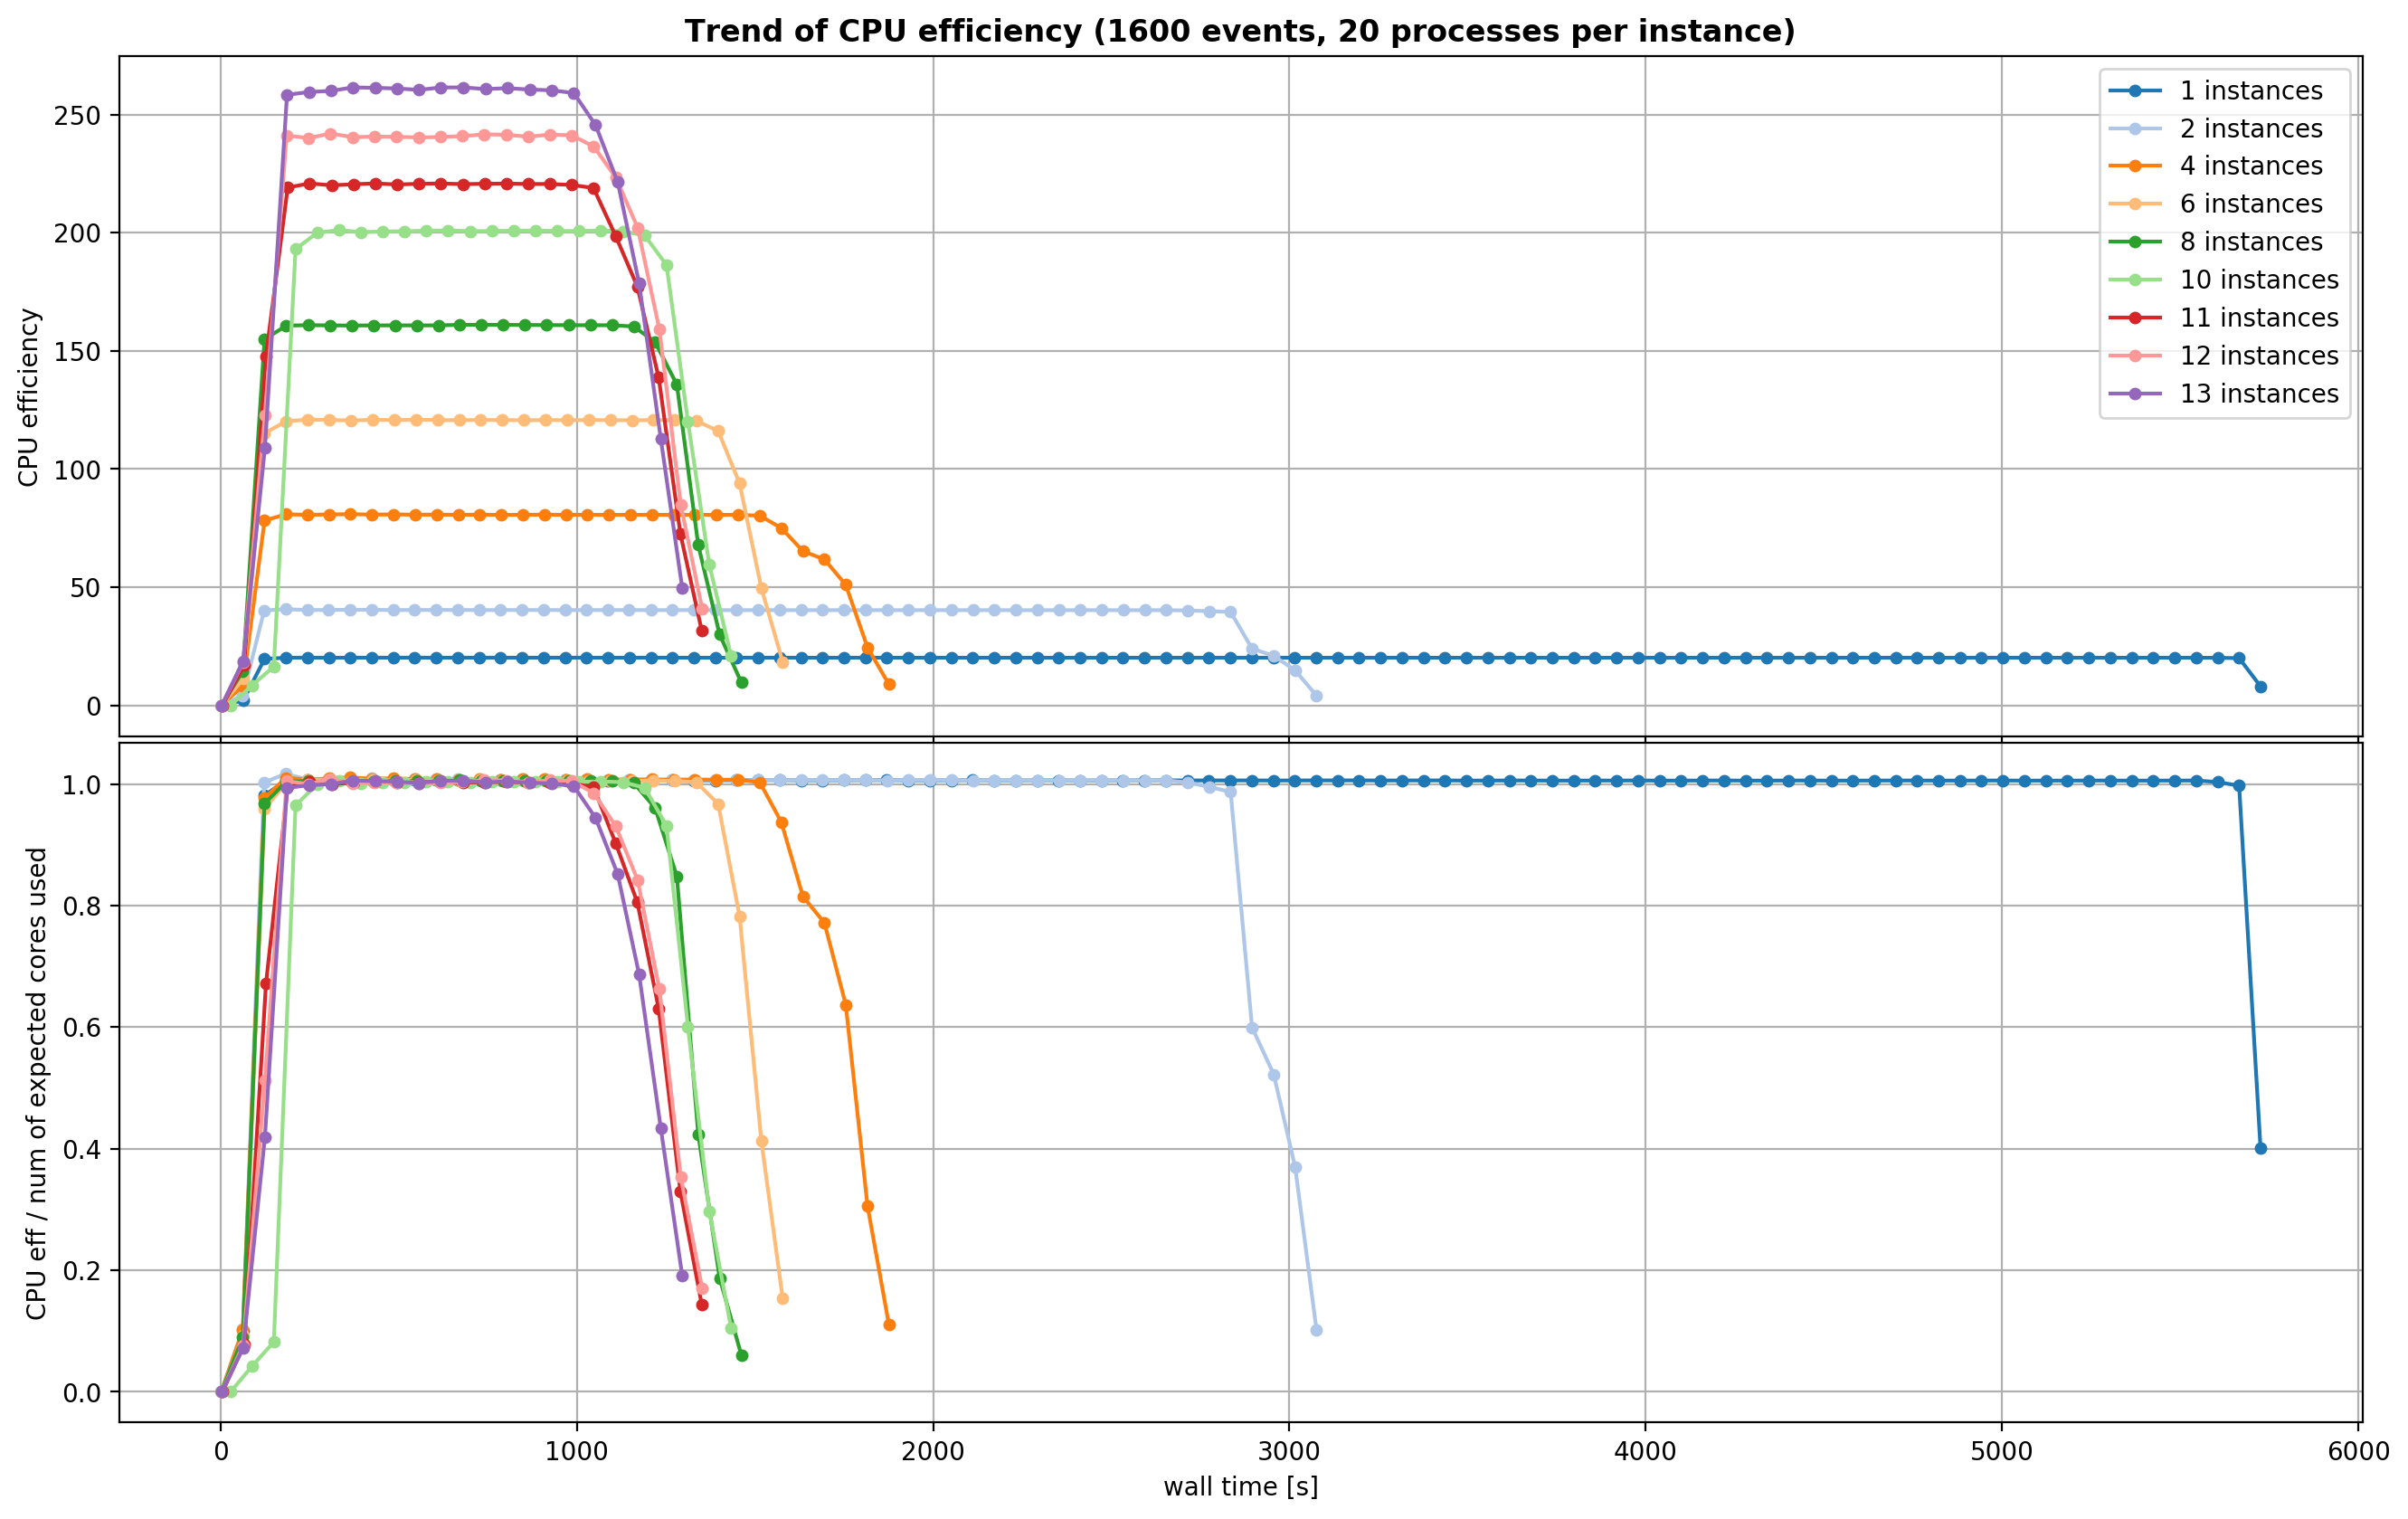

In [6]:
# Performance data over time for every job
psmon_slurm_raw = load_csv("psmon_slurm.csv", quiet=True)
psmon_not_ok = [ x["jobId"] for x in psmon_slurm_raw if x["nInst"] != x["nInstOk"] ]
psmon_raw = load_csv("psmon.csv", "rec['jobId'] not in psmon_not_ok", quiet=True)
#del psmon_slurm_raw, psmon_not_ok

psmon_fig = []
psmon_ax = []
for n_evt in sorted({x["nEvt"] for x in psmon_raw}):
    # For each event set, do a different plot
    fig,ax = plt.subplots(2, sharex="all")
    fig.subplots_adjust(hspace=0.01)
    psmon_fig.append(fig)
    psmon_ax.append(ax)
    cycol = cycler("color", get_cmap("tab20").colors).__iter__()
    for n_inst in sorted({x["nInst"] for x in psmon_raw if x["nEvt"] == n_evt}):
        # For each number of instances
        x,y1,ni,nj = get_tuple(psmon_raw, ("elapsed", "cpuEff", "nInst", "nProc"), {"nInst": n_inst, "nEvt": n_evt})
        # Also create normalized version
        y2 = []
        for i in range(len(y1)):
            y2.append(y1[i] / (ni[i] * nj[i]))
        prop = cycol.__next__()
        # Plot
        ax[0].plot(x, y1, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
        ax[1].plot(x, y2, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
    for a in ax:
        a.grid(True)
    ax[0].legend()
    ax[-1].set_xlabel("wall time [s]")
    ax[0].set_title(f"Trend of CPU efficiency ({n_evt} events, "
                    f"{psmon_raw[0]['nProc']} processes per instance)",
                    weight="bold")
    ax[0].set_ylabel("CPU efficiency");
    ax[1].set_ylabel("CPU eff / num of expected cores used")
del a, ax, fig, x, y1, y2, prop, cycol, n_inst, n_evt, ni, nj, i

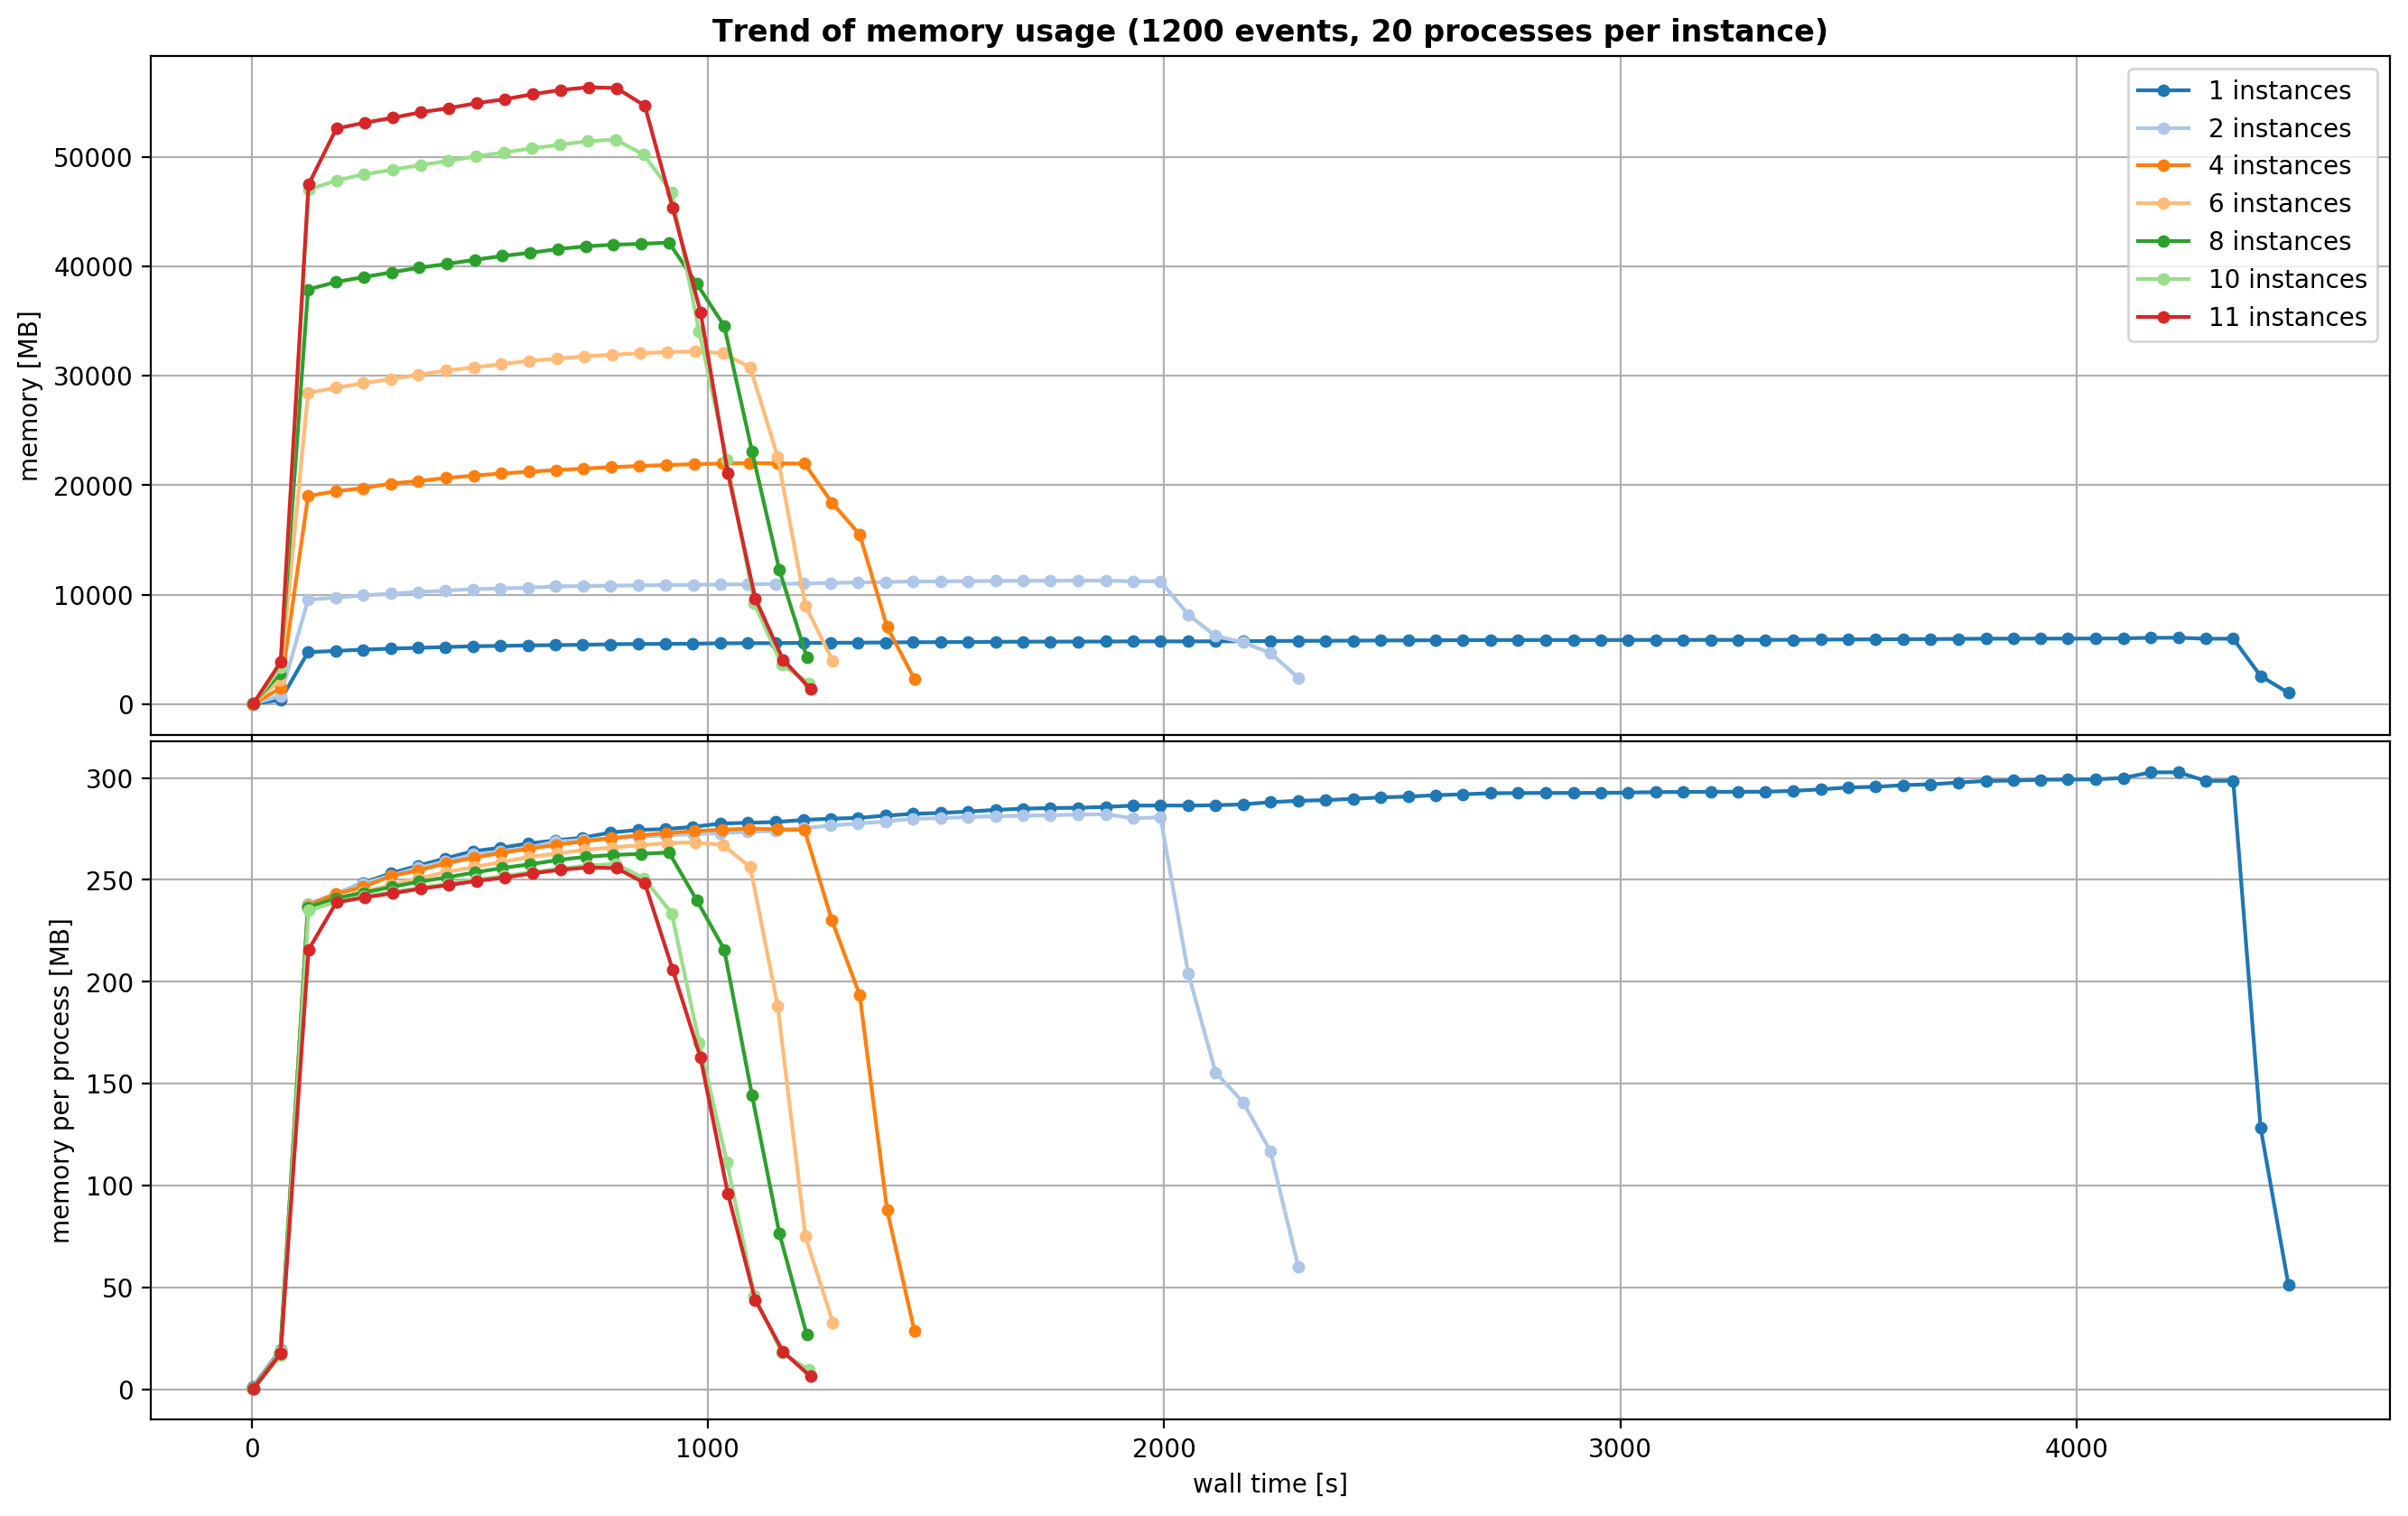

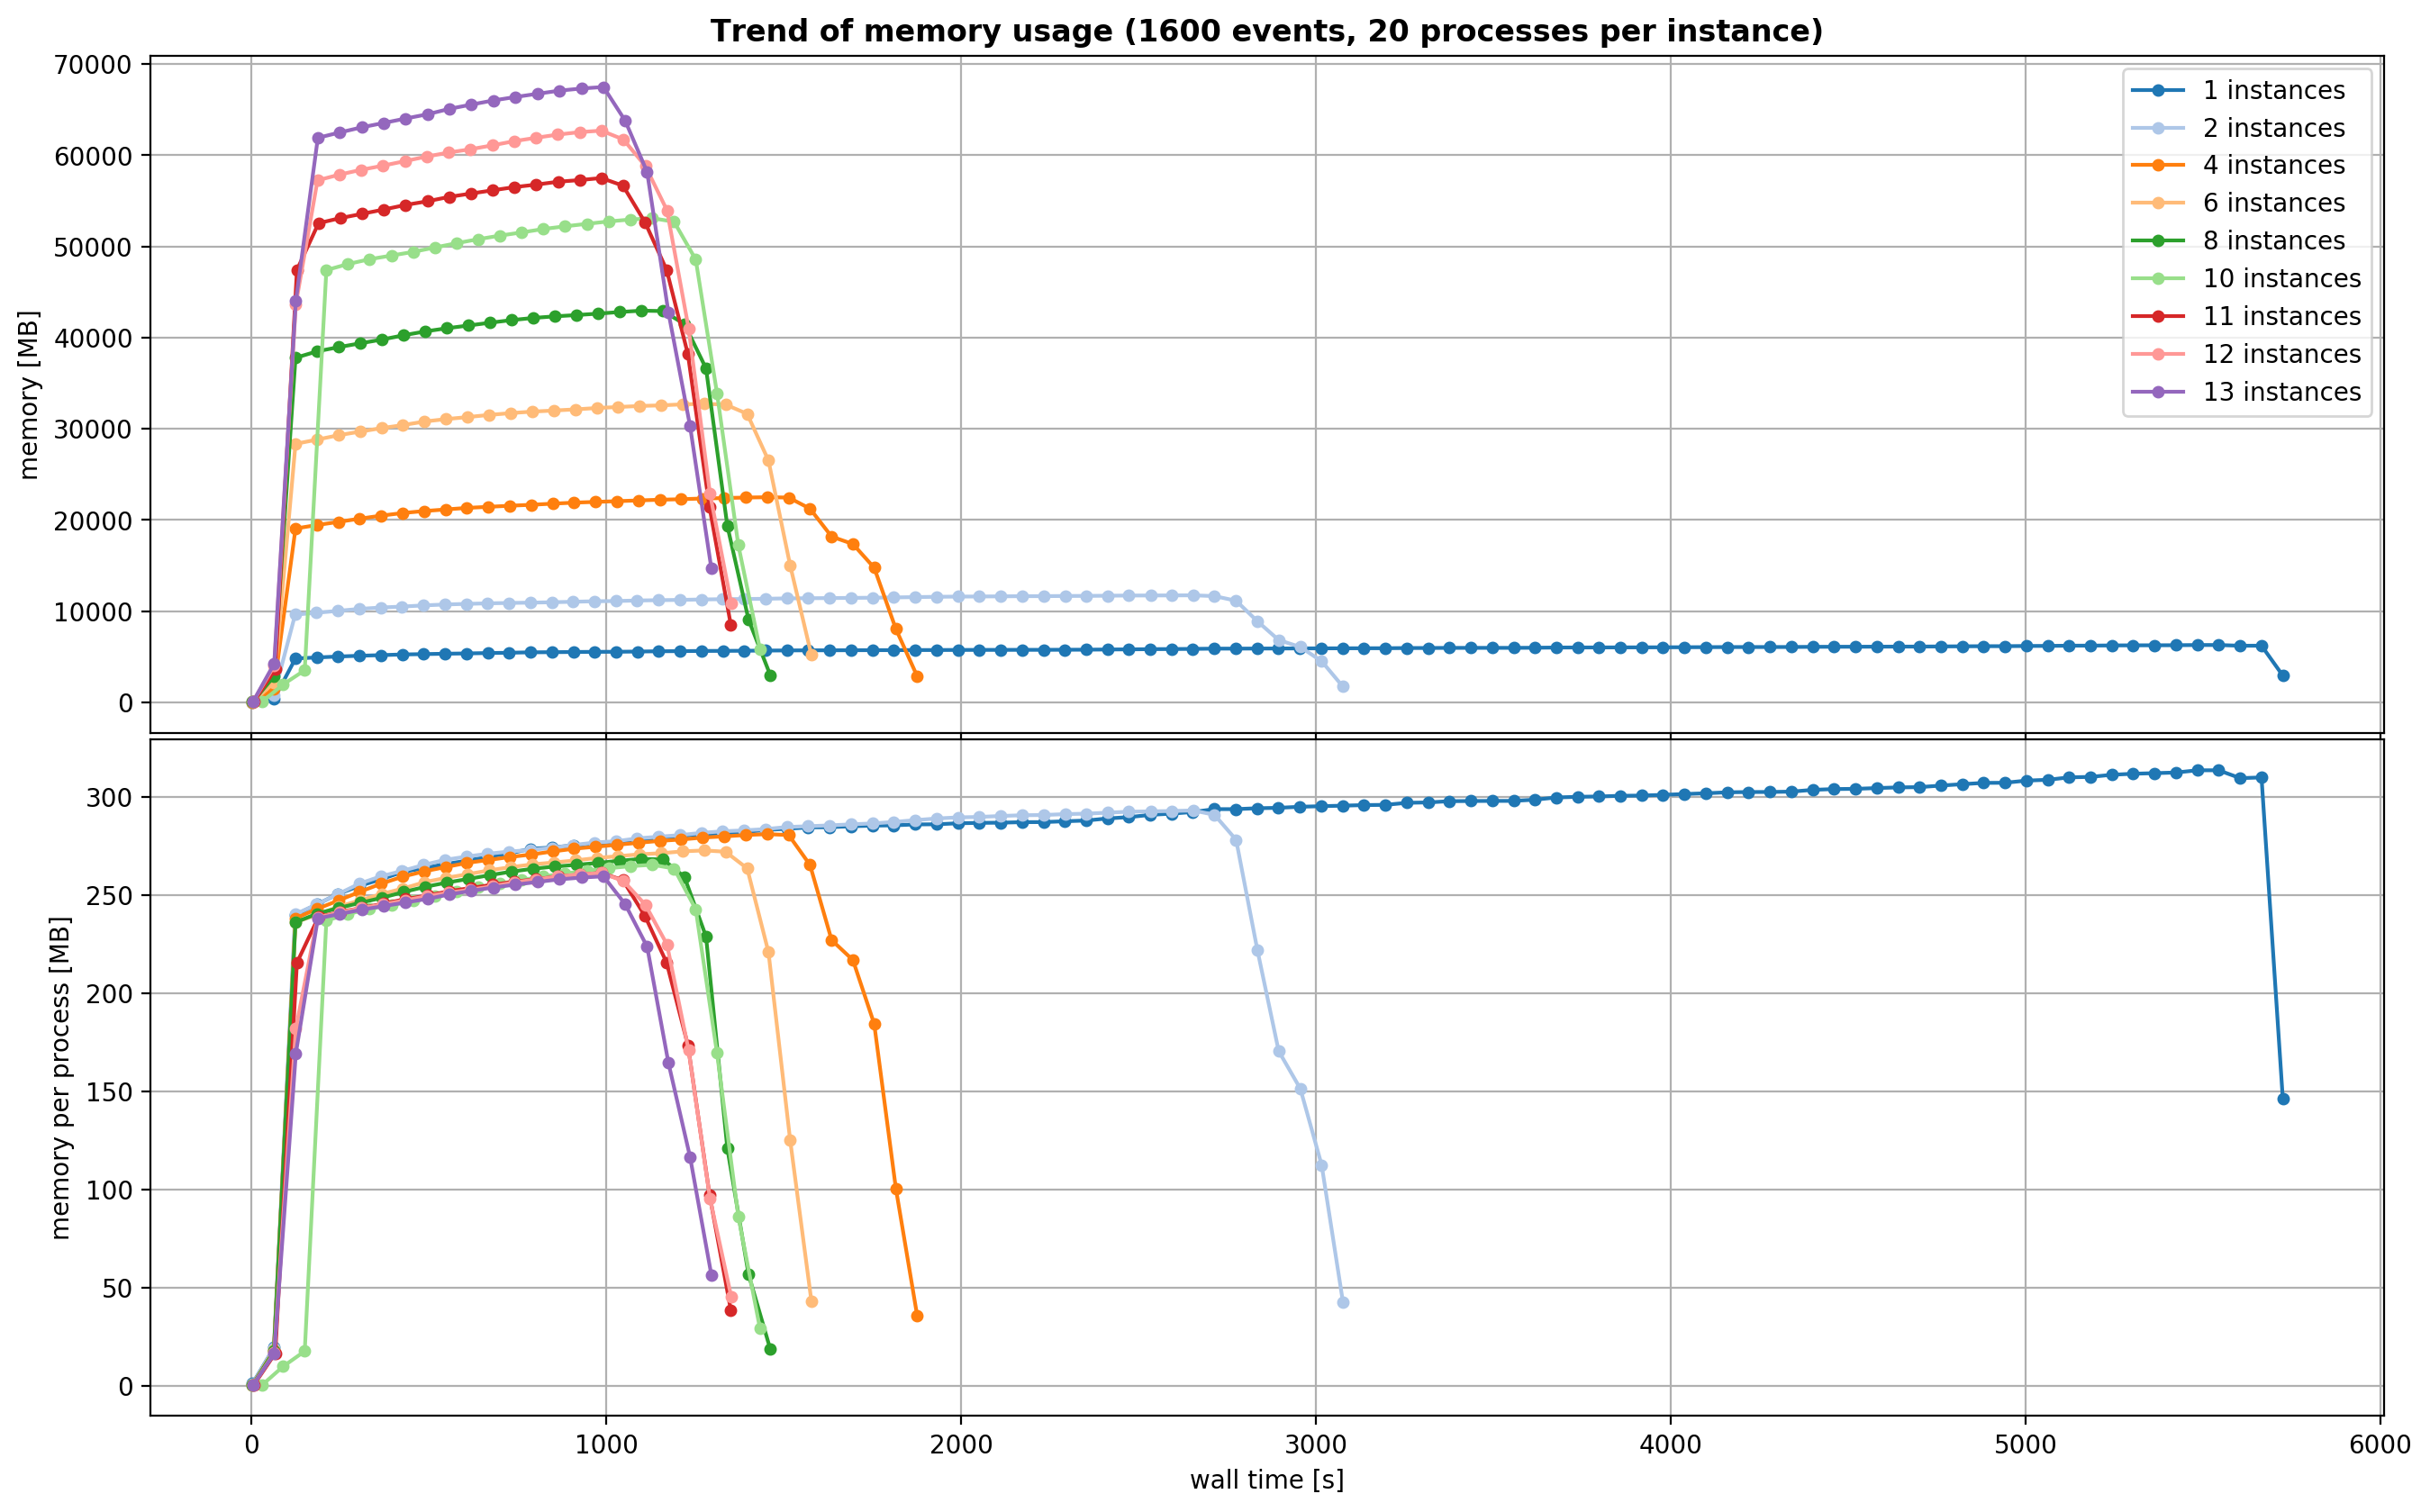

In [7]:
psmon_mem_fig = []
psmon_mem_ax = []
for n_evt in sorted({x["nEvt"] for x in psmon_raw}):
    # For each event set, do a different plot
    fig,ax = plt.subplots(2, sharex="all")
    fig.subplots_adjust(hspace=0.01)
    psmon_mem_fig.append(fig)
    psmon_mem_ax.append(ax)
    cycol = cycler("color", get_cmap("tab20").colors).__iter__()
    for n_inst in sorted({x["nInst"] for x in psmon_raw if x["nEvt"] == n_evt}):
        # For each number of instances
        x,y1,ni,nj = get_tuple(psmon_raw, ("elapsed", "rsz", "nInst", "nProc"), {"nInst": n_inst, "nEvt": n_evt})
        # Convert memory to MB
        y1 = [ i/1024 for i in y1 ]
        # Normalize
        y2 = []
        for i in range(len(y1)):
            y2.append(y1[i] / (ni[i] * nj[i]))
        prop = cycol.__next__()
        # Plot
        ax[0].plot(x, y1, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
        ax[1].plot(x, y2, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
    for a in ax:
        a.grid(True)
    ax[-1].set_xlabel("wall time [s]")  # only for the bottom-most plot
    ax[0].legend()  # only do legend for the first plot (it's the same below)
    ax[0].set_title(f"Trend of memory usage ({n_evt} events, "
                    f"{psmon_raw[0]['nProc']} processes per instance)",
                    weight="bold")
    ax[0].set_ylabel("memory [MB]");
    ax[1].set_ylabel("memory per process [MB]")
del a, ax, fig, x, y1, y2, prop, cycol, n_inst, n_evt, ni, nj, i

Keys from multi_slurm_stats.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss
Keys from multi_psmon.csv: jobId, nEvt, nProc, nInst, elapsed, cpuEff, vsz, rsz


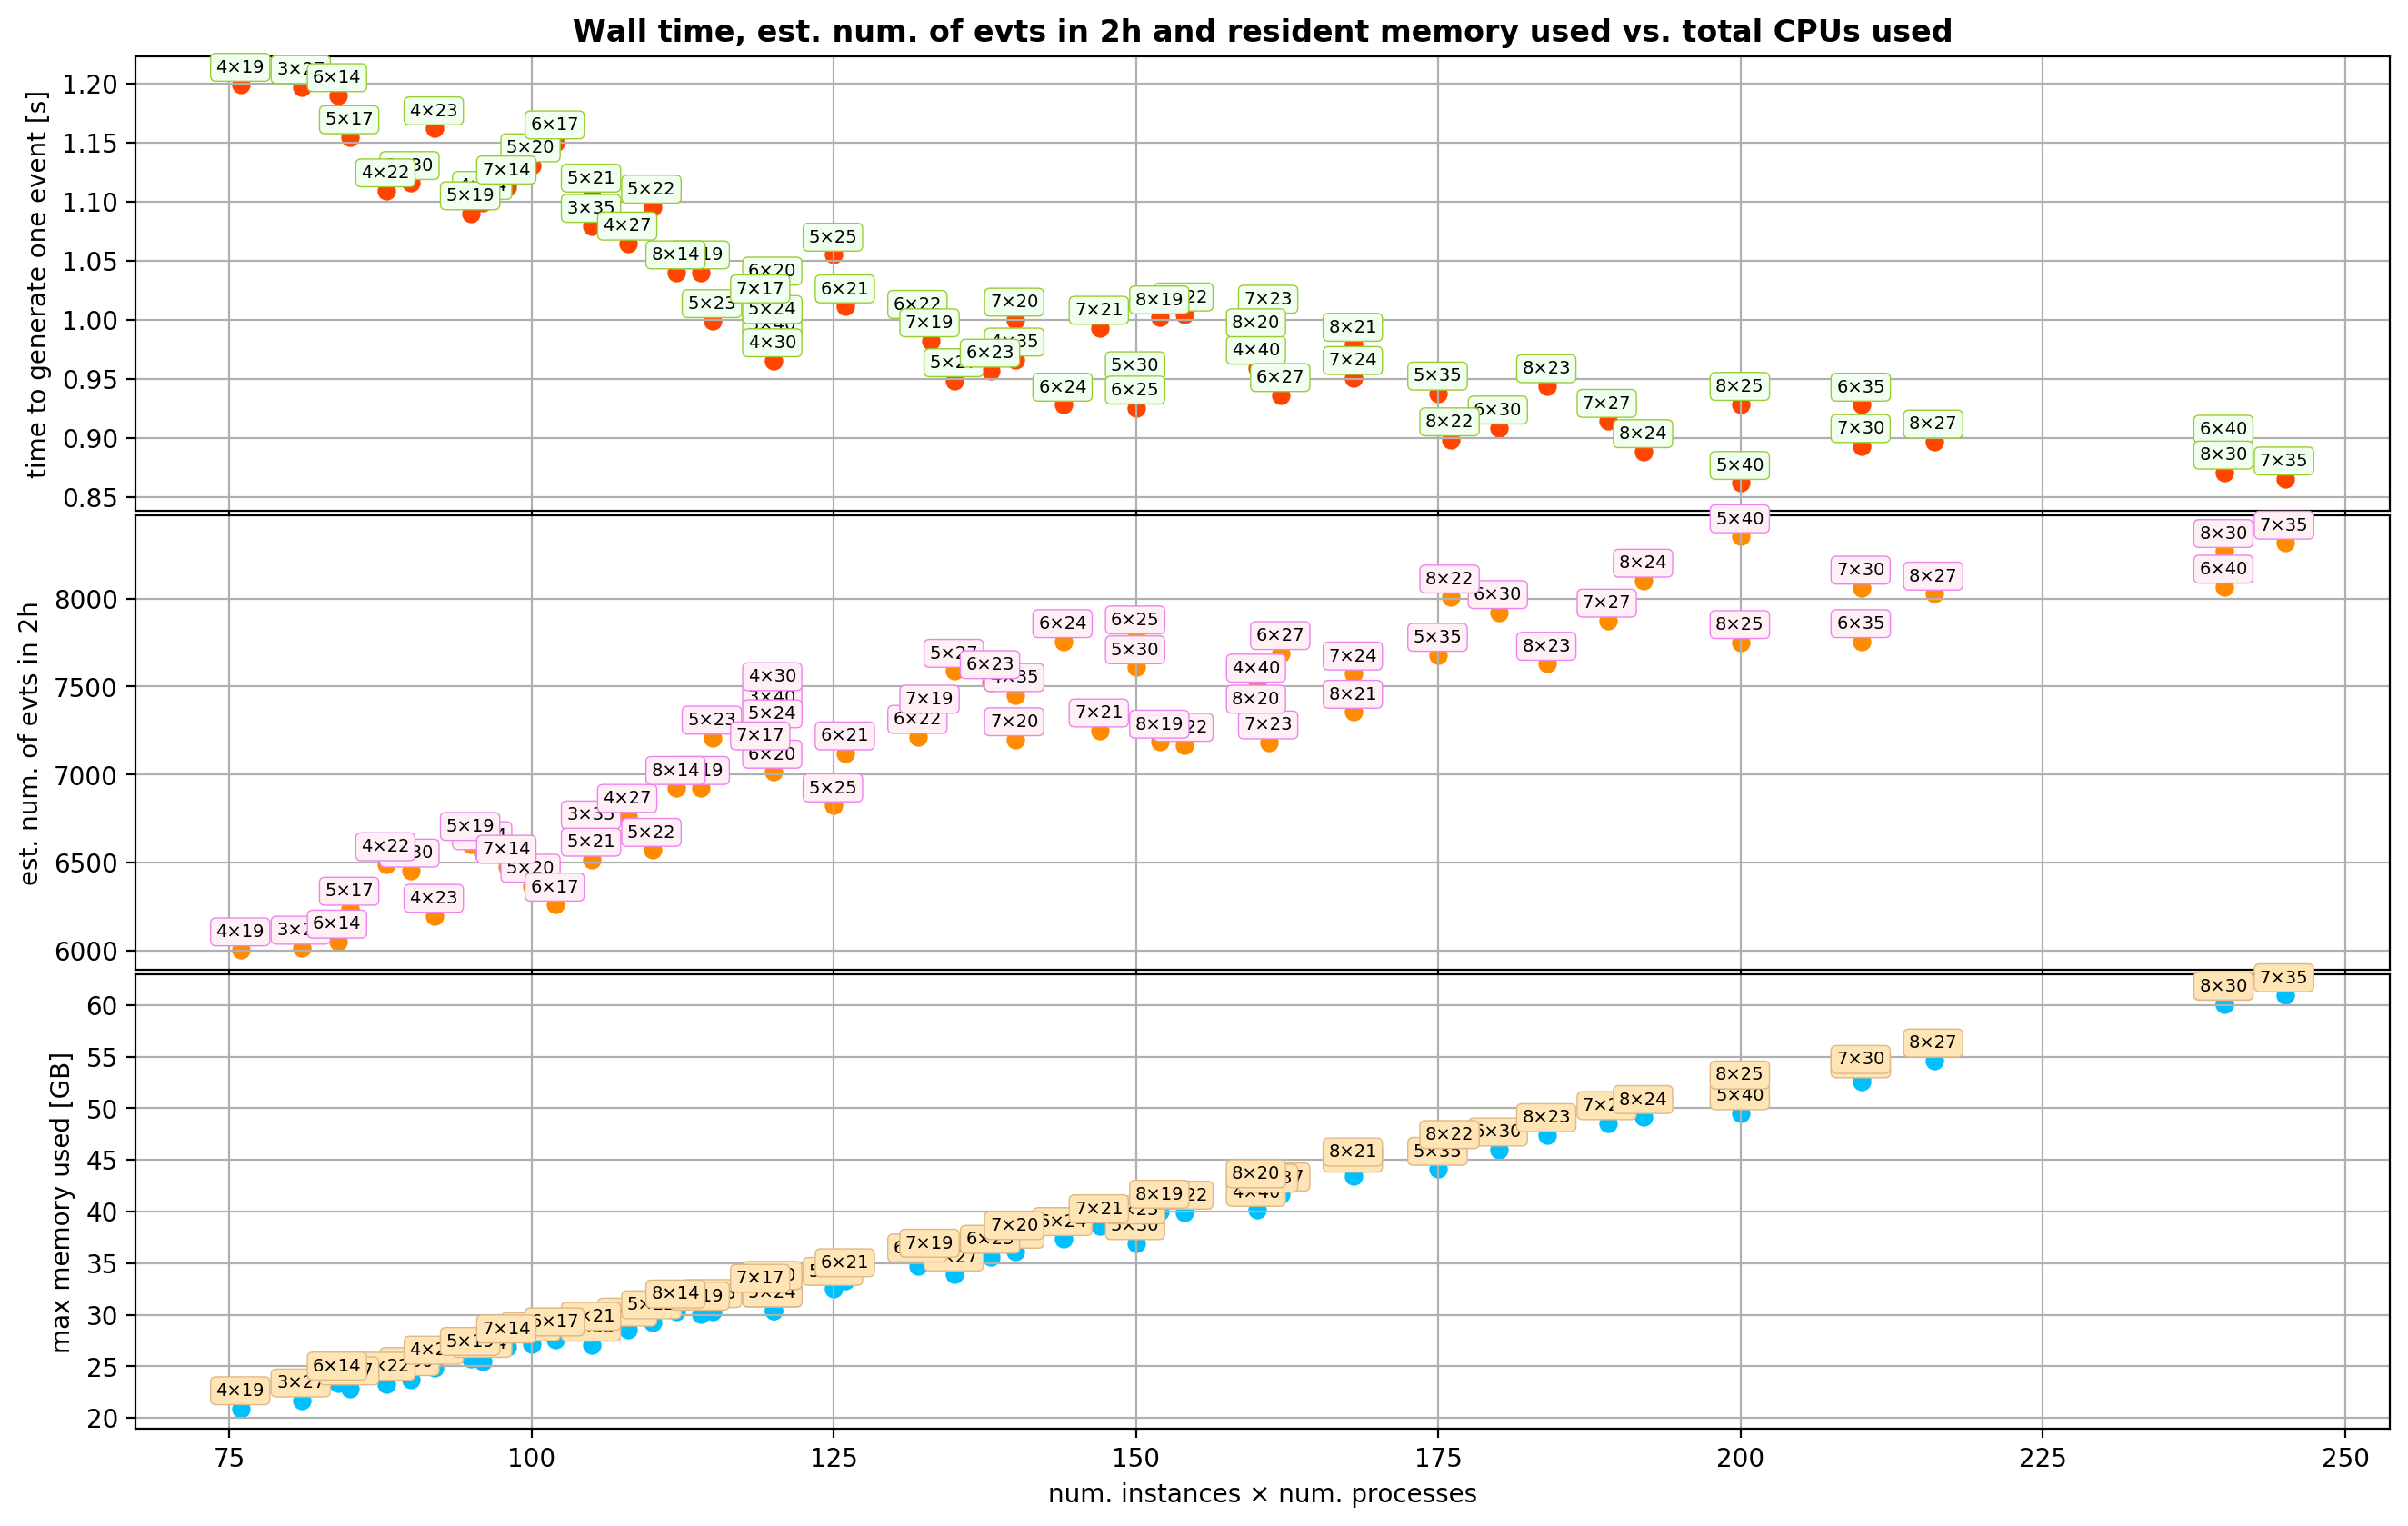

In [8]:
# Find the optimal combination of nProc vs. nInst
multi_raw = load_csv("multi_slurm_stats.csv")
multi_psmon_not_ok = [ x["jobId"] for x in multi_raw if x["nInst"] != x["nInstOk"] ]
multi_psmon_raw = load_csv("multi_psmon.csv", "rec['jobId'] not in multi_psmon_not_ok", quiet=True)
del multi_psmon_not_ok

# Only healthy jobs are selected (make sure there are no WARNINGs on stdout!)
jid,npr,nin,wt,nev = get_tuple(multi_raw, ("jobId", "nProc", "nInst", "slurmWallTime", "nEvt"),
                               cond_eval="x['nShMem'] == x['nInst'] and x['nInst'] == x['nInstOk']")
n_evt = nev[0]
del nev

# Convert to numpy arrays
jid = np.array(jid)
npr = np.array(npr)
nin = np.array(nin)
wt = np.array(wt)

# Add memories (note: using max memory, not avg, roughly corresponds to plateau)
mem = np.empty(len(jid))
for i,j in enumerate(jid):
    mems, = get_tuple(multi_psmon_raw, ("rsz",), cond={"jobId": j})
    mem_max = float(max(mems))
    mem[i] = mem_max
del mems, mem_max, i, j
mem /= 1024 * 1024  # result is in GB

# Compute derivative arrays
wtn = wt / n_evt   # wall time per event
ncp = npr * nin    # tot. number of used CPUs
gev = 7200 / wtn   # num. of events in 2h

# Filter all
cond = wtn < 1.2  # filter condition
show_ann = True   # whether to print annotations
jid = jid[cond]
npr = npr[cond]
nin = nin[cond]
wt = wt[cond]
wtn = wtn[cond]
ncp = ncp[cond]
gev = gev[cond]
mem = mem[cond]

# Plot
multi_fig,multi_ax = plt.subplots(3, sharex="all")
multi_fig.subplots_adjust(hspace=0.01)
multi_ax[0].scatter(ncp, wtn, marker="o", s=40, c="orangered")
multi_ax[0].set_ylabel("time to generate one event [s]")
multi_ax[1].scatter(ncp, gev, marker="o", s=40, c="darkorange")
multi_ax[1].set_ylabel("est. num. of evts in 2h")
multi_ax[2].scatter(ncp, mem, marker="o", s=40, c="deepskyblue")
multi_ax[2].set_ylabel("max memory used [GB]")
for ax in multi_ax:
    ax.grid(True)
multi_ax[0].set_title("Wall time, est. num. of evts in 2h and resident memory used vs. total CPUs used",
                      weight="bold")
multi_ax[-1].set_xlabel("num. instances × num. processes")

if show_ann:
    for i,ax in enumerate(multi_ax):
        if i == 0:
            # wall time per event
            ydata = wtn
            box_fc = "honeydew"
            box_ec = "yellowgreen"
        elif i == 1:
            # est. events in 2h
            ydata = gev
            box_fc = "lavenderblush"
            box_ec = "violet"
        elif i == 2:
            # est. events in 2h
            ydata = mem
            box_fc = "moccasin"
            box_ec = "burlywood"
        for i_npr,i_nin,i_ncp,i_y in zip(npr,nin,ncp,ydata):
            ax.annotate(s=f"{i_nin}×{i_npr}",
                        textcoords="offset points",
                        xy=(i_ncp, i_y),
                        xytext=(-10, 5),
                        fontsize=7,
                        bbox={"boxstyle": "round",
                              "fc": box_fc,
                              "ec": box_ec,
                              "lw": 0.5})
    del ydata, box_fc, box_ec, i_npr, i_nin, i_ncp, i_y, i

# del show_ann, ax, cond, npr, nin, ncp, gev, wt, wtn, n_evt

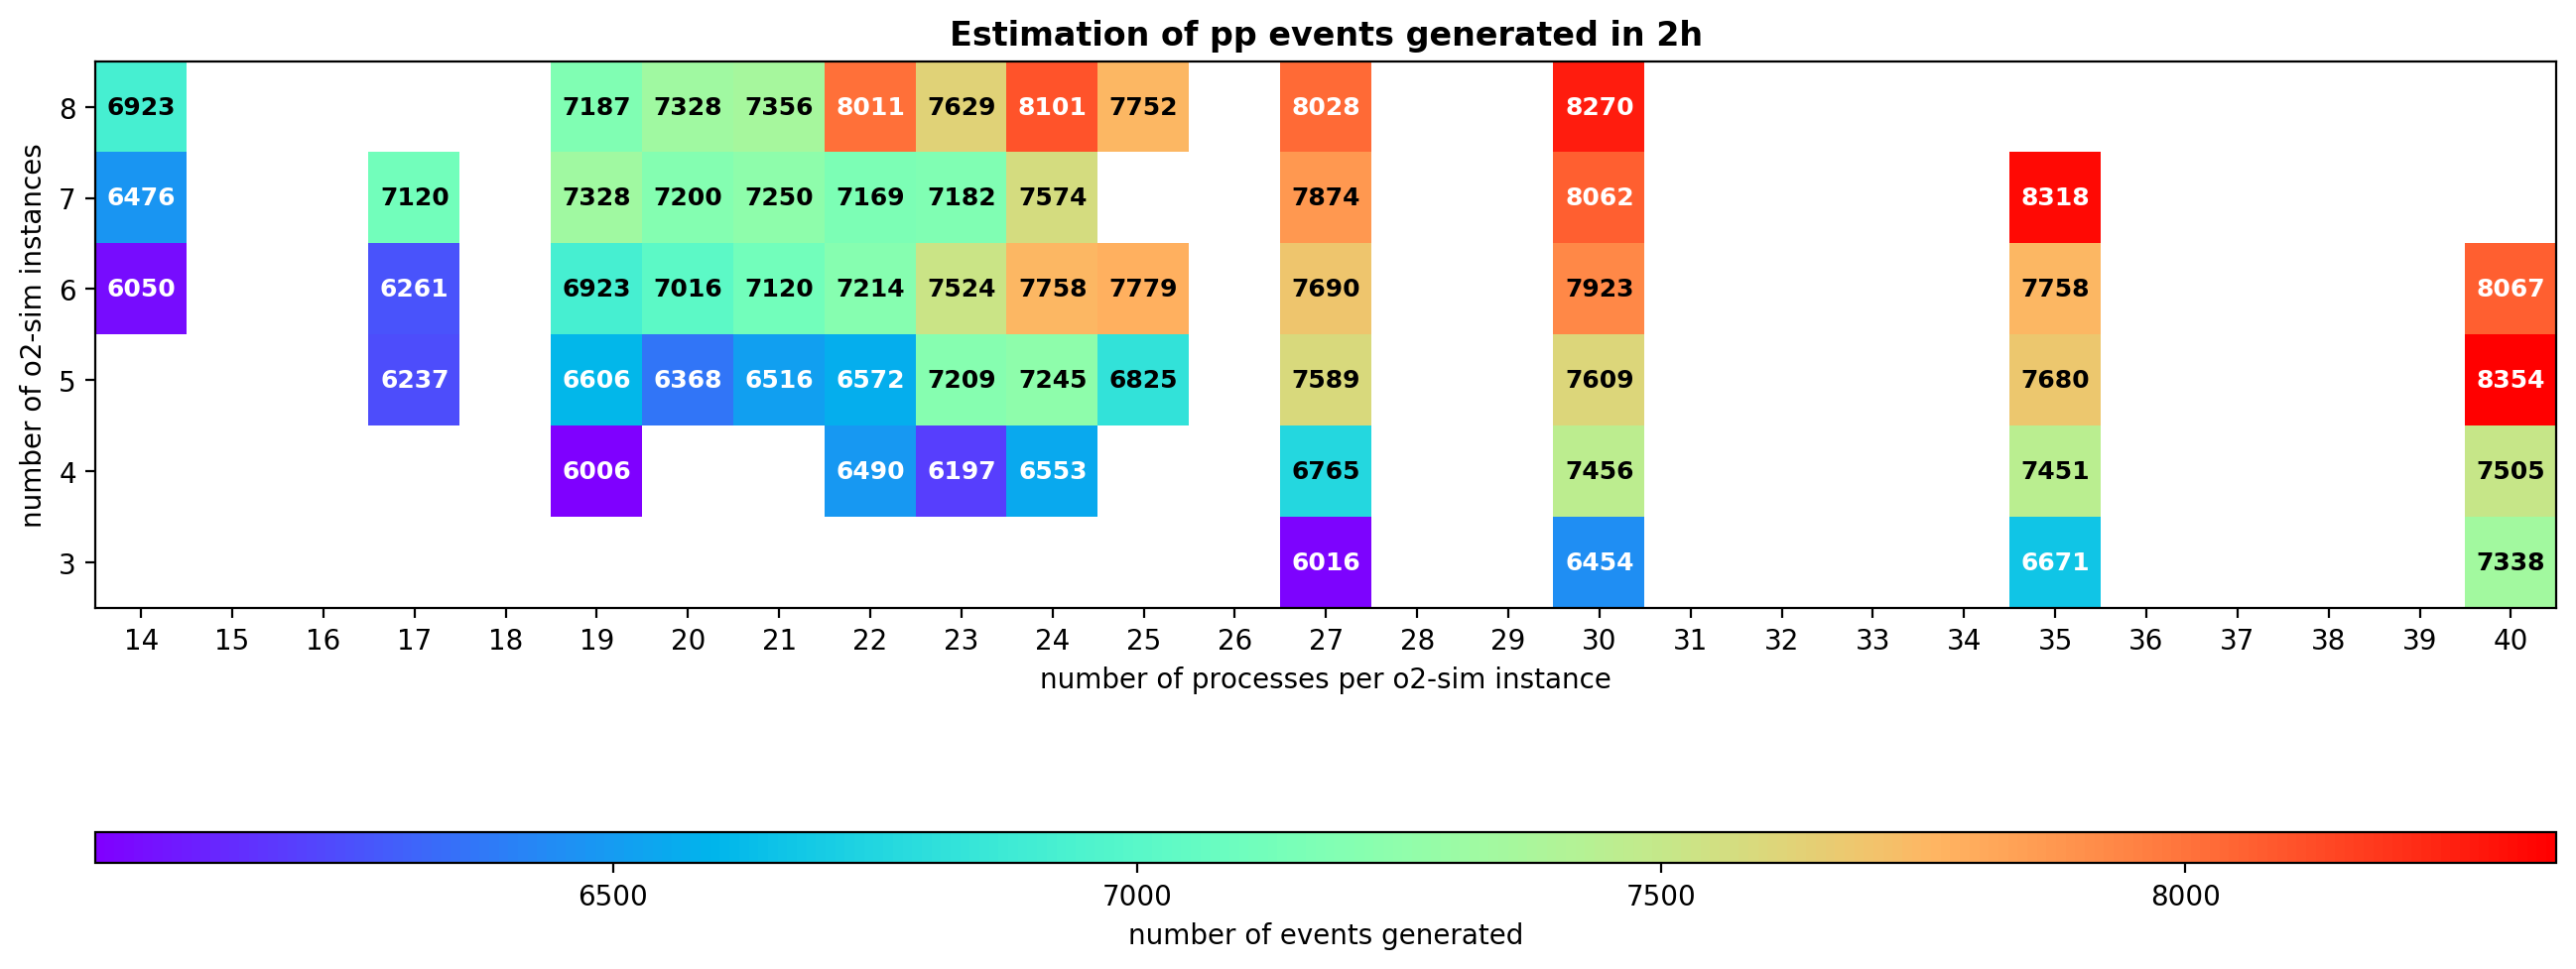

In [9]:
# Density plot using same data as above

a = npr
b = nin
c = gev
#c = mem

amin = min(a)
amax = max(a)
bmin = min(b)
bmax = max(b)
cmin = min(c)
cmax = max(c)

grid = np.full((bmax-bmin+1, amax-amin+1), np.nan)

cont = lambda aori, bori: (bori-bmin, aori-amin)
for t in zip(a, b, c):
    anew, bnew = cont(t[0], t[1])
    grid[anew, bnew] = t[2]
del t, anew, bnew, cont

dens_fig,dens_ax = plt.subplots()
dens_cmap = plt.get_cmap("rainbow")  # we need the object below
dens_grid = dens_ax.imshow(grid, cmap=dens_cmap, origin="lower")
dens_ax.set_xticks(np.arange(len(grid[0])))
dens_ax.set_yticks(np.arange(len(grid)))
dens_ax.set_xticklabels(np.arange(amin, amax+1))
dens_ax.set_yticklabels(np.arange(bmin, bmax+1))
dens_ax.set_xlabel("number of processes per o2-sim instance")
dens_ax.set_ylabel("number of o2-sim instances")
dens_ax.set_title("Estimation of pp events generated in 2h", weight="bold")
dens_cbar = dens_fig.colorbar(dens_grid, orientation="horizontal", aspect=80)
dens_cbar.set_label("number of events generated")

def get_contrast_color(c):
    if c[0] * 0.299 + c[1] * 0.587 + c[2] * 0.114 > 0.6:
        return "black"
    return "white"
    
for i in range(len(grid)):
    for j in range(len(grid[0])):
        if not np.isnan(grid[i, j]):
            val = grid[i, j]
            val_norm = (val-cmin) / (cmax-cmin)
            dens_ax.text(j, i, f"{val:.0f}",
                         fontsize=9, weight="bold",
                         ha="center", va="center",
                         color=get_contrast_color(dens_cmap(val_norm)[:3]))

del val, val_norm, i, j
del a, b, c, amin, amax, bmin, bmax, cmin, cmax, grid
del dens_cmap, dens_grid, dens_cbar

In [10]:
del show_ann, ax, cond, npr, nin, ncp, gev, wt, wtn, jid, mem, n_evt

In [11]:
# Check for variables
# [x for x in locals() if not x.startswith("_")]